# Feature Selection Notebook:

This notebook contains the code for preprocessing and feature selection.

We run the `preprocess_and_train` function from `preptrain.py` and save the selected features to a separate .csv file, `df_selected.csv`, which we use in our models in the `Models.ipynb`.

In [30]:
import pandas as pd
import numpy as np
import time

import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')
from preptrain import preprocess_and_train
from helper_functions import (print_dict_imps4x2, 
                              avg_imps, 
                              plot_corr_heatmap)

In [31]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
labels = df.pop("mvp_share")
stratify = df.pop("Rank")

In [3]:
start_time = time.time()

# Call the function to preprocess the data and perform feature selection
(features_rf,
 features_Dtree,
 features_pca, 
 features_gbm,
 features_svr, 
 features_Xtrees,
 features_Ada,
 features_XGB,
 feature_importances) = preprocess_and_train(df, df_last, labels)

end_time = time.time()
execution_time = end_time - start_time
print(f"Feature Selection execution time: {round(execution_time/60, 2)} minutes")

/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 'auto', 'linear'] before, using random point [0.7216203252171479, 'auto', 'poly']
  warnings.warn(
/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, 7, 1.0, 9, 20, 500] before, using random point [False, 5, 1.0, 3, 4, 393]
  warnings.warn(


Feature Selection execution time: 5.71 minutes


In [4]:
# Function call from helper_functions.py
print_dict_imps4x2(feature_importances)

       Random Forest                 Decision Tree                      PCA                           GBM             
│ Feature   │   Importance │  │ Feature   │   Importance │  │ Feature   │   Importance │  │ Feature   │   Importance │
╞═══════════╪══════════════╡  ╞═══════════╪══════════════╡  ╞═══════════╪══════════════╡  ╞═══════════╪══════════════╡
│ Rk_Conf   │      0.02927 │  │ FG%       │      0.02375 │  │ WS        │      0.21956 │  │ 2P        │      0.01717 │
├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤
│ Rk_Year   │      0.01662 │  │ STL%      │      0.01961 │  │ PTS       │      0.21866 │  │ BPM       │      0.01347 │
├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤
│ WS/48     │      0.00641 │  │ VORP      │      0       │  │ FG        │      0.21612 │  │ DWS       │      0.01017 │
├───────────┼──────────────┤  ├───────────┼─────

In [5]:
# Function call from helper_functions.py
avg_imp = avg_imps(feature_importances)

1. FG: 0.21612
2. FTA: 0.20676
3. MP: 0.20572
4. FT: 0.20551
5. PTS: 0.11329
6. FGA: 0.10208
7. 2P: 0.07540
8. weight: 0.04420
9. PER: 0.03598
10. VORP: 0.03508
11. WS: 0.03503
12. TOV: 0.02999
13. FG%: 0.02375
14. STL%: 0.01961
15. OBPM: 0.01918
16. Rk_Conf: 0.01871
17. BPM: 0.01597
18. DWS: 0.01202
19. OWS: 0.00995
20. Rk_Year: 0.00939
21. AST%: 0.00765
22. 3P: 0.00687
23. WS/48: 0.00441
24. Overall: 0.00118
Top 10 Features: ['FG', 'FTA', 'MP', 'FT', 'PTS', 'FGA', '2P', 'weight', 'PER', 'VORP']


#### The selected features make sense (except for weight). However, many relate to points (scoring) and are highly correlated, for example:

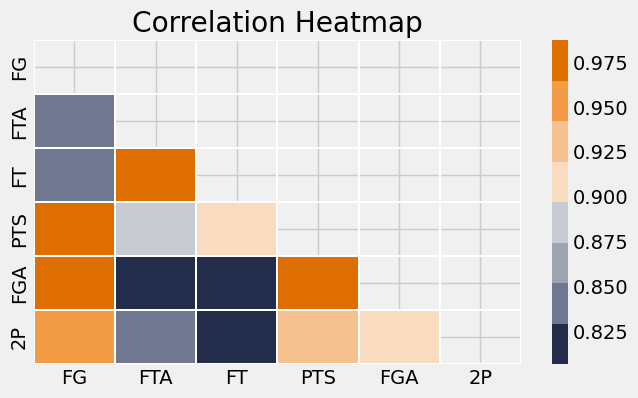

In [9]:
score_related = df[['FG', 'FTA', 'FT', 'PTS', 'FGA', '2P']]

corr_matrix = score_related.corr()
plot_corr_heatmap(corr_matrix, score_related, 0.2, 7, 4, False)

#### Points (PTS) captures all of these, for the most part, so we drop FTA, FGA, FG, 2P, and FT. We also drop weight as it only appeared once.

#### Moving to the next-highest features in terms of importance, we get:

1. MP
2. PTS
3. PER
4. VORP
5. WS
6. TOV
7. FG%
8. STL%
9. BPM
10. Rk_Conf

#### FG% is also highly correlated with PTS, so we drop that as well. This brings in BPM, which is highly correlated with OBPM, so we drop the latter in favor of the former. To replace FG%, now the next candidate features are DWS and OWS, which are correlated with WS, so we do not include those. The next option is Rk_Year, which is highly correlated with Rk_Conf and likely captures more than just conference ranking, so we include Rk_Year instead of Rk_Conf. Finally, we get AST%. So, our final set of ten features are:

1. MP
2. PTS
3. PER
4. VORP
5. WS
6. TOV
7. STL%
8. BPM
9. Rk_Year
10. AST%

In [33]:
selected_features = ['MP', 'PTS', 'PER', 'VORP', 'WS', 'TOV', 'STL%', 'BPM', 'Rk_Year', 'AST%']

---

## Selected Features:

- MP = Minutes Played.

- PTS = Points.

- PER = Player Efficiency Rating (see <a href="https://www.basketball-reference.com/about/per.html">Calculating PER</a> for the formula).

- VORP = Value Over Replacement Player

- WS = Win Shares (see <a href="https://www.basketball-reference.com/about/ws.html">NBA Win Shares)</a> for information about how this feature is calculated).

- TOV = Turnovers.

- STL% = Steal percentage.

- BPM = Box Plus-Minus.

- Rk_Year = Team Ranking.

- AST% = Assist percentage.

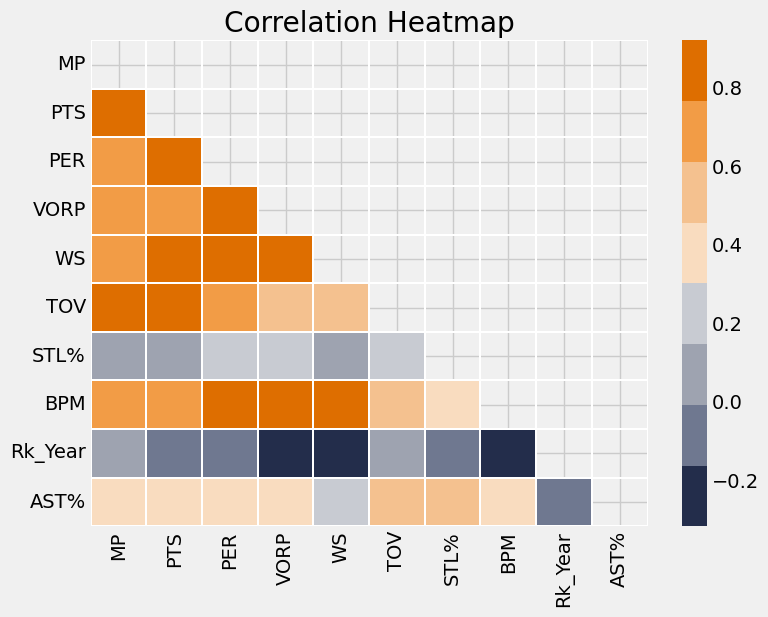

In [34]:
# Select only the columns corresponding to the top 10 features
df_check_selected = df[selected_features]
corr_matrix = df_check_selected.corr()

plot_corr_heatmap(corr_matrix, selected_features, 0.6, 8, 6, False)

### Some features are highly correlated, but we proceed to modeling and index buidling for now.

In [35]:
df_selected = df[selected_features]
df_selected.to_csv('df_selected.csv', index=False)